In [1]:
using Pkg
using LinearAlgebra
using Plots
using Distributions
using Random
using StateSpaceDynamics
using StatsBase

const SSD = StateSpaceDynamics

StateSpaceDynamics

In [2]:
"""
Create an underlying GaussianHMM to generate data
"""

# Create Guassian Emission Models
output_dim = 2
μ = [0.0, 0.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_1 = GaussianEmission(output_dim, μ, Σ)

μ = [2.0, 1.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_2 = GaussianEmission(output_dim, μ, Σ)

# Create GaussianHMM
true_model = SSD.GaussianHMM(K=2, output_dim=2)
true_model.B[1] = emission_1
true_model.B[2] = emission_2
true_model.A = [0.9 0.1; 0.8 0.2]

# Sample from the model
n=1000
true_labels, data = SSD.sample(true_model, n=n)


# Fit a gaussian hmm to the data
test_model = SSD.GaussianHMM(K=2, output_dim=2)
ll = SSD.fit!(test_model, data)

New Function in use...


Running EM algorithm...   2%|█                           |  ETA: 0:01:35

Running EM algorithm... 100%|████████████████████████████| Time: 0:00:02


28-element Vector{Float64}:
   -Inf
 -2189.4510245439537
 -1397.7324290455201
 -1397.7273171097947
 -1397.6818517351473
 -1397.1976851036684
 -1392.12452728206
 -1350.1866639334025
 -1208.6572957146961
 -1132.5861998834218
     ⋮
  -978.1329977688467
  -972.982971707286
  -965.7454243043945
  -953.8761525942806
  -933.3023154987787
  -910.2208997164062
  -907.1304315278721
  -907.1297196608673
  -907.1297196574363

In [3]:
"""
Create a new GaussianHMM and try to fit the synthetic data
"""
n = 10  # Number of samples per trial
num_trials = 3  # Number of trials
trial_inputs = Vector{Matrix{Float64}}(undef, num_trials)  # Vector to store data matrices
trial_labels = Vector{Vector{Int}}(undef, num_trials)  # Vector to store label vectors
trial_outputs = Vector{Matrix{Float64}}(undef, num_trials)

for i in 1:num_trials
    true_labels, data = SSD.sample(true_model, n=n)  # Generate data and labels
    trial_labels[i] = true_labels  # Store labels for the ith trial
    trial_inputs[i] = data  # Store data matrix for the ith trial

    true_labels, data = SSD.sample(true_model, n=n)  # Generate data and labels
    trial_outputs[i] = data  # Store data matrix for the ith trial
end

In [4]:
"""
Generate a multiple trial GaussianHMM Dataset from the fit model
"""
model2 =SSD.GaussianHMM(K=2, output_dim=2)
ll = SSD.fit!(model2, trial_inputs)

Using new GLM function


12-element Vector{Float64}:
 -Inf
 -71.64190440559824
 -51.884512490474904
 -50.28003369174613
 -46.31983692988655
 -39.832683469478084
 -37.37795163835957
 -36.97767697327244
 -35.1436658743236
 -29.511197317991964
 -29.470976515278416
 -29.470976515278355

In [5]:
model3 = SSD.SwitchingGaussianRegression(K=2, input_dim=2, output_dim=2)
ll2 = SSD.fit!(model3, trial_outputs, trial_inputs, max_iters=100)

Using new GLM function


Running EM algorithm...   2%|█                           |  ETA: 0:02:35

Running EM algorithm... 100%|████████████████████████████| Time: 0:00:03


23-element Vector{Float64}:
 -Inf
 -98.73403035353083
 -69.92997422175105
 -62.944760320057554
 -59.82681309025191
 -53.86993667733646
 -51.22764134620101
 -40.13956156203372
 -13.991790437087454
 -13.698036418649734
   ⋮
  33.28709054689518
 -13.69749741150586
  26.211307785317153
 -13.697497462373528
 -13.697858384842307
  34.612578561846775
 -13.697497419475267
 -13.697858385064185
 -13.697858478723063

In [9]:

# Function to sample from initial state and transition matrix
function sample_states(num_samples, initial_probs, transition_matrix)
    states = Vector{Int}(undef, num_samples)
    states[1] = rand(Categorical(initial_probs))  # Initial state
    for i in 2:num_samples
        states[i] = rand(Categorical(transition_matrix[states[i - 1], :]))  # State transitions
    end
    return states
end


# Create a true underlying model
model = SSD.SwitchingGaussianRegression(K=2, input_dim=1, output_dim=1)
model.B[1].β = [100; 100;;]
model.B[2].β = [-100; -100;;]
model.B[1].Σ = [2.0;;]
model.B[2].Σ = [3.0;;]

# Define initial state probabilities (π) and transition matrix (A)
initial_probs = [0.6, 0.4]  # Probability to start in state 1 or state 2
transition_matrix = [0.9 0.1; 0.4 0.6]  # State transition probabilities

n = 100 # Number of samples per trial
num_trials = 50  # Number of trials
n1_std = 10
n2_std = 5

# Vectors to store generated data
trial_inputs = Vector{Matrix{Float64}}(undef, num_trials)
trial_labels = Vector{Vector{Int}}(undef, num_trials)
trial_outputs = Vector{Matrix{Float64}}(undef, num_trials)



# Generate trials
for trial in 1:num_trials
    # Random input data
    x_data = randn(n, 1)  # Random input data for this trial
    trial_inputs[trial] = x_data

    # Generate state sequence
    state_sequence = sample_states(n, initial_probs, transition_matrix)
    trial_labels[trial] = state_sequence

    # Generate output data based on state and linear relationships
    y_data = zeros(n, 1)
    for i in 1:n
        if state_sequence[i] == 1
            y_data[i] = (model.B[1].β[2] * x_data[i] + model.B[1].β[1]) + (randn() * n1_std)
        else
            y_data[i] = (model.B[2].β[2] * x_data[i] + model.B[2].β[1]) + (randn() * n2_std)
        end
    end
    trial_outputs[trial] = y_data
end

# Create new model and fit the data
est_model = SSD.SwitchingGaussianRegression(K=2, input_dim=1, output_dim=1)
ll = SSD.fit!(est_model, trial_inputs, trial_outputs, max_iters=200)

# Run tests to assess model fit
print(isapprox(est_model.B[1].β, model.B[1].β, atol=0.1) || isapprox(est_model.B[1].β, model.B[2].β, atol=0.1))
print(isapprox(est_model.B[2].β, model.B[2].β, atol=0.1) || isapprox(est_model.B[2].β, model.B[1].β, atol=0.1))
print(isapprox(est_model.B[1].Σ, model.B[1].Σ, atol=0.01) || isapprox(est_model.B[1].Σ, model.B[2].Σ, atol=0.01))
print(isapprox(est_model.B[2].Σ, model.B[2].Σ, atol=0.01) || isapprox(est_model.B[2].Σ, model.B[1].Σ, atol=0.01))




Using new GLM function
falsefalsefalsefalse

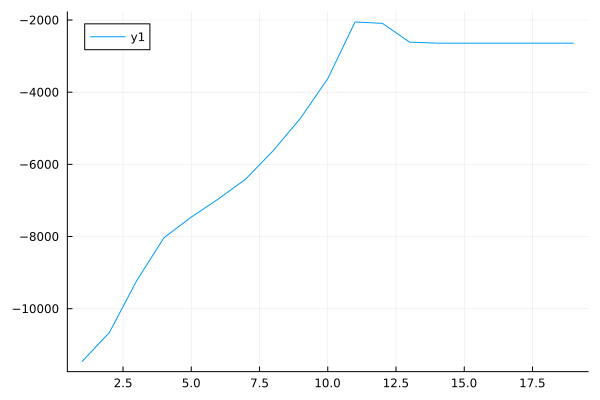

In [10]:
plot(ll[3:end])

In [11]:
println(est_model.B[1].β)
println(est_model.B[2].β)

println(model.B[1].β)
println(model.B[2].β)


println(est_model.B[1].Σ[1])
println(est_model.B[2].Σ[1])

[-0.99694939533911; -0.00999022313153658;;]
[-0.9864608698205446; 0.009875694198878519;;]
[100; 100;;]
[-100; -100;;]
0.0004073338211939091
0.008183634343777455
